# Get Nbody Candidates

In [3]:
import rebound
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
%matplotlib inline

### Load data and stability predictions for System

In [5]:
system = "Kepler-431"    #KOI-0156, KOI-0168, KOI-2086, Kepler-431

data = pd.read_csv("systems/%s_data.csv"%system)
results = pd.read_csv("systems/%s_results.csv"%system)
Ms = {}; Ms["KOI-0156"] = 0.56; Ms["KOI-0168"] = 1.11; Ms["KOI-2086"] = 1.04; Ms["Kepler-431"] = 1.071;
epoch = 780

#get e
try:
    data["e1"] = np.sqrt(data["h1"]**2 + data["k1"]**2)
    data["e2"] = np.sqrt(data["h2"]**2 + data["k2"]**2)
    data["e3"] = np.sqrt(data["h3"]**2 + data["k3"]**2)
except:
    print "can't find h and k entries, calculating."
    data["h1"], data["k1"] = data["e1"]*np.sin(data["w1"]), data["e1"]*np.cos(data["w1"])
    data["h2"], data["k2"] = data["e2"]*np.sin(data["w2"]), data["e2"]*np.cos(data["w2"])
    data["h3"], data["k3"] = data["e3"]*np.sin(data["w3"]), data["e3"]*np.cos(data["w3"])

can't find h and k entries, calculating.


### Get Nbody candidates for Sunnyvale
Randomly sample from three stability probability ranges (low, medium, high).

In [12]:
N_samples = 249
random.seed(42)

#index = random.sample(results.index, N_samples)

# i1 = random.sample(np.where((results["predict_proba"] > 0)&(results["predict_proba"] < 0.5))[0],N_samples/3)
# i2 = random.sample(np.where((results["predict_proba"] > 0.5)&(results["predict_proba"] < 0.85))[0],N_samples/3)
# i3 = random.sample(np.where((results["predict_proba"] > 0.85)&(results["predict_proba"] <= 1))[0],N_samples/3)
# index = np.concatenate((i1,i2,i3))

index = data.index

In [13]:
data.loc[index].head()

,Unnamed: 0,m1,MA1,P1,e1,w1,m2,MA2,P2,e2,...,MA3,P3,e3,w3,h1,k1,h2,k2,h3,k3
0,0,0.190323,1.922614,6.803,0.013274,2.076118,0.548149,5.444703,8.703,0.003679,...,5.983768,11.922,0.000372,4.412395,0.011615,-0.006426,-0.002055,0.003051,-0.000356,-0.000110
1,1,0.362025,0.952130,6.803,0.000496,1.162948,0.276461,4.141902,8.703,0.001693,...,1.206019,11.922,0.025620,6.009131,0.000456,0.000197,-0.001598,-0.000560,-0.006934,0.024664
2,2,1.109612,2.163423,6.803,0.119979,3.065306,0.078009,3.863810,8.703,0.070324,...,5.599364,11.922,0.000017,0.285293,0.009144,-0.119630,0.033663,-0.061744,0.000005,0.000016
3,3,0.139435,3.290191,6.803,0.134269,6.111329,0.620793,2.178322,8.703,0.012962,...,0.395234,11.922,0.000155,2.807998,-0.022962,0.132291,-0.002742,0.012669,0.000051,-0.000146
4,4,0.239099,4.372711,6.803,0.000517,0.758024,0.796238,0.305502,8.703,0.034731,...,0.896373,11.922,0.000118,1.670759,0.000355,0.000376,-0.033463,0.009299,0.000117,-0.000012


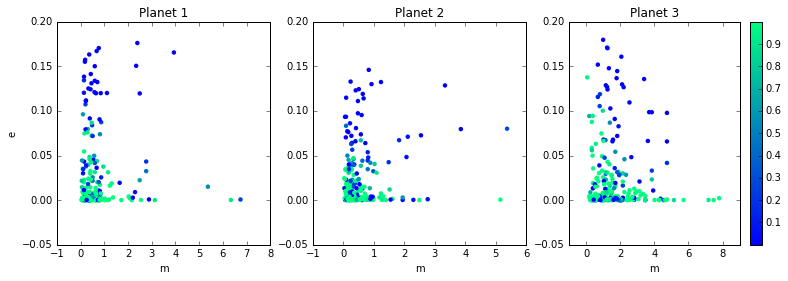

In [19]:
# Plot Nbody Candidates
x = "m"
y = "e"
proba = results["predict_proba"].loc[index].values

colorbar = 'winter'
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[13, 4])
ax1.scatter(data["%s1"%x].loc[index], data["%s1"%y].loc[index], c=proba, cmap=colorbar, lw=0)
ax2.scatter(data["%s2"%x].loc[index], data["%s2"%y].loc[index], c=proba, cmap=colorbar, lw=0)
c=ax3.scatter(data["%s3"%x].loc[index], data["%s3"%y].loc[index], c=proba, cmap=colorbar, lw=0)

ax1.set_ylabel(y) 
ax1.set_xlabel(x)
ax2.set_xlabel(x)
ax3.set_xlabel(x)
ax1.set_title("Planet 1")
ax2.set_title("Planet 2")
ax3.set_title("Planet 3")
cb = f.colorbar(c)
plt.savefig("images/%s_%s%s_Nbodycandidates.png"%(system,x,y))

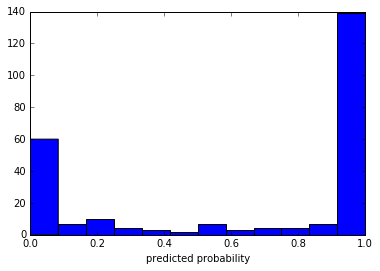

In [15]:
plt.hist(proba, 12);
plt.xlabel('predicted probability')

## Make Sunnyvale Jobs

In [20]:
norbits = 1e9            #number of orbits of innermost planet
dir = 'jobs/'

f2 = open("systems/%s_NbodyIDs.csv"%system,"w"); f2.write("Nbody IDs\n")
for shadow in [0,1]:
    for sample in data.loc[index].iterrows():
        id_ = sample[0]    #id number of sample
        job_name = "%s_1e%dorbits_id%d_shadow%d"%(system,int(np.log10(norbits)),id_,shadow)
        sh_script_name = "%s%s"%(dir,job_name)
        with open(sh_script_name, 'w') as f:
            f_head = open('job_header_sunnyvale','r')
            f.write(f_head.read())
            f_head.close()
            f.write('#PBS -N %s \n'%job_name)
            f.write('# EVERYTHING ABOVE THIS COMMENT IS NECESSARY, SHOULD ONLY CHANGE nodes,ppn,walltime and my_job_name VALUES\n')
            f.write('cd $PBS_O_WORKDIR\n')      #This will be the home stability_predict directory
            f.write('source ../venv/bin/activate \n')
            f.write('python run_Nbody.py %d %f %.2f %d %d %s >& batch.output\n'%(id_,Ms[system],epoch,norbits,shadow,job_name))
        f.close()
        if shadow == 0:
            f2.write("%d\n"%id_)
f2.close()